In [34]:
import random
import plot_epoch
from math import hypot,pi,cos,sin,sqrt,exp


In [3]:
class W: #env
    def __init__(self,n,QModel):
        self.ens=[EN(n-2,n-2,n)]#,EN(n-2,n-1,n),EN(n-1,n-2,n),EN(n-1,n-1,n)]
        self.P=P(1,1,n,self.ens,QModel,self)
        self.n=n
        self.QM=QModel
        self.QM.get_wp(self.P)

    def step(self):
        self.P.move()
        for i in self.ens:
            i.move()

        
    def pr(self,silent=1):
        """print map"""
        #print('\n'*100)
        px,py=self.P.getxy()
        self.wmap=list([[0 for i in range(self.n)] for j in range(self.n)])
        self.wmap[py][px]=1
        for i in self.ens:
            ex,ey=i.getxy()
            self.wmap[ey][ex]=2
        if not silent:
            for i in self.wmap:
                print(i)

    def is_finished(self):
        px,py=self.P.getxy()
        end_bool=True
        for i in self.ens:
            ex,ey=i.getxy()
            end_bool=end_bool and ((px,py)!=(ex,ey))
        return end_bool

    def get_reward(self,end_bool):
        if end_bool:
            self.P.reward=1
        else:
            self.P.reward=-1

    def play(self,silent=1,silent_run=1):
        end_bool=self.is_finished()
        iter=0
        while end_bool:
            self.pr(silent)
            self.step()
            end_bool=self.is_finished()
            self.get_reward(end_bool)
            if silent_run:
                self.QM.run_model(silent)
            if not silent:
                print('___')
            iter=iter+1
        return iter

In [4]:
class un: #unit
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.actions=[(0,0),(-1,-1),(0,-1),(1,-1),(-1,0),
                       (1,0),(-1,1),(0,1),(1,1)]
    def getxy(self):
        return self.x, self.y

In [5]:
class EN(un): #spy
    def __init__(self,x,y,n):
        self.n=n
        un.__init__(self,x,y)

    def move(self):
        expr=False
        cou=0
        while not expr:
            act=random.choice(self.actions)
            a=self.x+act[0]
            b=self.y+act[1]
            expr=((0<=a<self.n) and (0<=b<self.n))
            if expr:
                self.x=a
                self.y=b

In [41]:
class Q:
    def __init__(self, sarsa = 0):
        self.sarsa = sarsa
        self.gamma=0.95
        self.alpha=0.05
        self.state={}

    def get_wp(self,plr):
        self.plr=plr

    def run_model(self,silent=1):
        self.plr.prev_state=self.plr.curr_state[:-2]+(self.plr.dx,self.plr.dy)
        self.plr.curr_state=tuple(self.plr.get_features(self.plr.x,self.plr.y))+(self.plr.dx,self.plr.dy)

        if not silent:
            print(self.plr.prev_state)
            print(self.plr.curr_state)

        r=self.plr.reward   

        if self.plr.prev_state not in self.state:
            self.state[self.plr.prev_state]=0
        nvec=[]
        if self.sarsa == 0:
            for i in self.plr.actions:
                cstate=self.plr.curr_state[:-2]+(i[0],i[1])
                
                if cstate not in self.state:
                    self.state[cstate]=0
                nvec.append(self.state[cstate])
            nvec=max(nvec)
            #print(nvec)
        else:
            i = random.choice(self.plr.actions)
            cstate = self.plr.curr_state[:-2]+(i[0],i[1])
            if cstate not in self.state:
                self.state[cstate]=0
            nvec = self.state[cstate]

        self.state[self.plr.prev_state]=self.state[self.plr.prev_state]+self.alpha*(
                                       -self.state[self.plr.prev_state]+r+self.gamma*nvec)

In [42]:
class P(un): #agent
    def __init__(self,x,y,n,ens,QM,wrld):
        self.wrld=wrld
        self.QM=QM
        self.ens=ens
        self.n=n
        self.dx=0
        self.dy=0
        self.eps=0.95
        self.prev_state=tuple(self.get_features(x,y))+(self.dx,self.dy)
        self.curr_state=tuple(self.get_features(x,y))+(self.dx,self.dy)
        un.__init__(self,x,y)
        
    def f1_no_data(self, x, y):
        features=[]
        return features
    
    def f2_euclidian(self, x, y):
        features=[]
        for i in self.ens: 
            ex,ey=i.getxy()
            dx=abs(x-ex)
            dy=abs(y-ey)
            l=hypot(dx,dy)
            features.append(l)
        to_brdr=min(x,y,self.n-1-x,self.n-1-y)
        features.append(to_brdr)
        return features
    def f3_sight(self, x, y):
        features=[]
        for i in self.ens:
            ex,ey=i.getxy()
            features.append(x-ex)
            features.append(y-ey)
        # if near wall x & y.
        if x==0:
            features.append(-1)
        elif x==self.n-1:
            features.append(1)
        else:
            features.append(0)
        if y==0:
            features.append(-1)
        elif y==self.n-1:
            features.append(1)
        else:
            features.append(0)
        return features
    def get_features(self,x,y):
        return self.f2_euclidian(x,y) + self.f3_sight(x, y)
        features=[]
        for i in self.ens:
            ex,ey=i.getxy()
            features.append(ex)
            features.append(ey)
        features.append(x)
        features.append(y)
        return features
    
        

    def strtg(self):
        if random.random()<self.eps:
            act=random.choice(self.actions)
        else:
            name1=tuple(self.get_features(self.x,self.y))
            best=[(0,0),float('-inf')]
            for i in self.actions:
                namea=name1+(i[0],i[1])
                if namea not in self.QM.state:
                    self.QM.state[namea]=0
                if best[1]<self.QM.state[namea]:
                    best=[i,self.QM.state[namea]]
            act=best[0]

        return act
    
    def move(self):
        self.dx,self.dy=self.strtg()
        a=self.x+self.dx
        b=self.y+self.dy
        expr=((0<=a<self.n) and (0<=b<self.n))
        if expr:
            self.x=a
            self.y=b

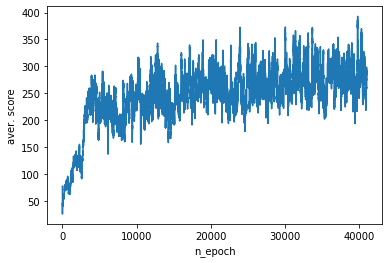

___
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
(2.8284271247461903, 1, -2, -2, 0, 0, 1, -1)
(4.0, 0, 0, -4, 0, -1, 1, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
(4.0, 0, 0, -4, 0, -1, 0, 0)
(3.1622776601683795, 0, 1, -3, 0, -1, 0, 0)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, 1, -3, 0, -1, -1, -1)
(4.123105625617661, 0, 1, -4, 0, -1, -1, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
(4.0, 0, 0, -4, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
(4.0, 0, 0, -4, 0, -1, 0, 0)
(4.123105625617661, 0, 1, -4, 0, -1, 0, 0)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
(3.0, 0, 0, -3, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[

___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -1, -2, 0, -1, 1, -1)
(2.8284271247461903, 0, -2, -2, 0, -1, 1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.8284271247461903, 0, -2, -2, 0, -1, 0, 0)
(3.605551275463989, 0, -2, -3, 0, -1, 0, 0)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
(3.605551275463989, 0, -2, -3, 0, -1, 0, 0)
(5.0, 0, -3, -4, 0, -1, 0, 0)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 2]
(5.0, 0, -3, -4, 0, -1, 1, 0)
(4.47213595499958, 0, -2, -4, 0, -1, 1, 0)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 2]
(4.47213595499958, 0, -2, -4, 0, -1, -1, -1)
(4.47213595499958, 0, -2, -4, 0, -1, -1, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 2]
(4.47213595499958, 0, -2, -4, 0, -1, -1, -1)
(4.123105625617661, 0, -1, -4, 0, -

[0, 0, 0, 1, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, 2, -1, 0, -1, -1, -1)
(3.605551275463989, 0, 3, -2, 0, -1, -1, -1)
___
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.605551275463989, 0, 3, -2, 0, -1, -1, -1)
(3.605551275463989, 0, 2, -3, 0, -1, -1, -1)
___
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.605551275463989, 0, 2, -3, 0, -1, -1, 0)
(3.0, 0, 0, -3, 0, -1, -1, 0)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 0, -3, 0, -1, -1, -1)
(4.0, 0, 0, -4, 0, -1, -1, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
(4.0, 0, 0, -4, 0, -1, 0, 0)
(4.123105625617661, 0, -1, -4, 0, -1, 0, 0)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
(4.123105625617661, 0, -1, -4, 0, -1, 0, -1)
(3.0, 0, 0, -3, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[

___
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 1, -1, 2, 0, 0, -1, -1)
(2.0, 0, -2, 0, -1, 0, -1, -1)
___
[0, 0, 0, 0, 0]
[1, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, -2, 0, -1, 0, -1, 0)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 0)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, -1)
(2.0, 0, -2, 0, -1, 0, -1, -1)
___
[0, 0, 0, 0, 0]
[1, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, -2, 0, -1, 0, -1, 0)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 0)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, -1)
(2.0, 0, -2, 0, -1, 0, -1, -1)
___
[0, 0, 0, 0, 0]
[1, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, -2, 0, -1, 0, -1, 0)
(1.4142135623730951, 0, -1, -1, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 2,

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.0, 0, -4, 0, -1, 0, -1, 1)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, -1)
(2.23606797749979, 0, -2, 1, -1, 0, -1, -1)
___
[0, 0, 2, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -2, 1, -1, 0, -1, 0)
(3.0, 0, -3, 0, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, -3, 0, -1, 0, 0, 0)
(3.1622776601683795, 0, -3, -1, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, -1, -1, 0, 0, 0)
(4.0, 0, -4, 0, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.0, 0, -4, 0, -1, 0, -1, 1)
(3.1622776601683795, 0, -3, -1, -1, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3

[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
___
[0, 0, 0, 0, 2]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 0)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, -1)
(4.123105625617661, 0, -4, 1, -1, 0, -1, -1)
___
[0, 0, 0, 0, 2]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 0)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, -1)
(4.123105625617661, 0, -4, 1, -1, 0, -1, -1)
___
[0, 0, 0, 0, 2]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
(4.0, 0, -4, 0, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 2]
[0, 0,

[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, -1, -1, 0, 0, 0)
(4.47213595499958, 0, -4, -2, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
(4.47213595499958, 0, -4, -2, -1, 0, 0, 1)
(4.0, 0, -4, 0, -1, 0, 0, 1)
___
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.0, 0, -4, 0, -1, 0, -1, 1)
(3.1622776601683795, 0, -3, -1, -1, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, -1, -1, 0, 0, 0)
(2.8284271247461903, 0, -2, -2, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
(2.8284271247461903, 0, -2, -2, -1, 0, 1, -1)
(2.23606797749979, 1, -1, -2, 0, 0, 1, -1)
___
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 1, -1, -2, 0, 0, 0, -1)
(3.605551275463989, 0, -2, -3, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0,

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.4142135623730951, 0, 1, -1, 0, -1, 1, 1)
(3.1622776601683795, 1, 3, 1, 0, 0, 1, 1)
___
[2, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 1, 3, 1, 0, 0, 0, -1)
(3.0, 0, 3, 0, 0, -1, 0, -1)
___
[2, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 3, 0, 0, -1, 0, 0)
(3.0, 0, 3, 0, 0, -1, 0, 0)
___
[2, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 3, 0, 0, -1, 0, 0)
(2.23606797749979, 0, 2, -1, 0, -1, 0, 0)
___
[0, 0, 0, 1, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, 2, -1, 0, -1, -1, -1)
(2.23606797749979, 0, 2, -1, 0, -1, -1, -1)
___
[0, 0, 0, 1, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, 2, -1, 0, -1, -1, -1)
(3.1622776601683795, 0, 3, -1, 0, -1, -1, -1)
___
[0, 0, 0, 1, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0

[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, 1, -2, 0, -1, -1, -1)
(2.0, 0, 0, -2, 0, -1, -1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, 0, -2, 0, -1, 0, -1)
(2.23606797749979, 0, -1, -2, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -1, -2, 0, -1, 1, -1)
(2.23606797749979, 0, -1, -2, 0, -1, 1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -1, -2, 0, -1, 1, -1)
(2.0, 0, 0, -2, 0, -1, 1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, 0, -2, 0, -1, 0, -1)
(1.4142135623730951, 0, 1, -1, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.4142135623730951, 0, 1, -1, 0, -1, 1, 1)
(1.4142135623730951, 1, 1, 1, 0, 0, 1, 1)
___
[0, 2, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0

[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
(4.123105625617661, 0, -4, 1, -1, 0, -1, 1)
___
[0, 0, 0, 0, 2]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 0)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
(2.0, 0, -2, 0, -1, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[1, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, -2, 0, -1, 0, -1, 0)
(2.0, 0, -2, 0, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, -2, 0, -1, 0, -1, 0)
(1.0, 0, -1, 0, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.0, 0, -1, 0, -1, 0, -1, 0)
(1.0, 0, 0, -1, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]

[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -1, -2, 0, -1, 1, -1)
(2.23606797749979, 0, -2, -1, 0, -1, 1, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -2, -1, 0, -1, -1, 1)
(2.23606797749979, 1, -2, 1, 0, 0, -1, 1)
___
[0, 0, 0, 2, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 1, -2, 1, 0, 0, -1, 0)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 0)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
(4.0, 0, -4, 0, -1, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.0, 0, -4, 0, -1, 0, -1, 1)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
(3.0, 0, -3, 0, -1, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.0, 1, 0, 1, 0, 0, 0, 1)
(1.0, 1, 0, 1, 0, 0, 0, 1)
___
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.0, 1, 0, 1, 0, 0, 0, 1)
(3.1622776601683795, 1, -1, 3, 0, 0, 0, 1)
___
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 1, -1, 3, 0, 0, -1, -1)
(2.23606797749979, 0, -1, 2, -1, 0, -1, -1)
___
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -1, 2, -1, 0, 1, 0)
(1.0, 1, 0, 1, 0, 0, 1, 0)
___
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.0, 1, 0, 1, 0, 0, 0, 1)
(2.23606797749979, 1, 1, 2, 0, 0, 0, 1)
___
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 1, 1, 2, 0, 0, 1, -1)
(1.4142135623730951, 2, 1, 1, 0, 0, 1, -1)
___
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.414213562373

[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -1, -3, 0, -1, 0, 0)
(2.0, 0, 0, -2, 0, -1, 0, 0)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, 0, -2, 0, -1, 0, -1)
(3.1622776601683795, 0, 1, -3, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, 1, -3, 0, -1, 0, -1)
(3.0, 0, 0, -3, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 0, -3, 0, -1, -1, -1)
(3.1622776601683795, 0, -1, -3, 0, -1, -1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -1, -3, 0, -1, -1, -1)
(3.1622776601683795, 0, -1, -3, 0, -1, -1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -1, -3, 0, -1, -1, -1)
(2.8284271247461903, 0, -2, -2, 0, -1, -1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0,

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
(4.123105625617661, 0, -1, -4, 0, -1, 0, -1)
(3.1622776601683795, 0, -1, -3, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -1, -3, 0, -1, 0, -1)
(3.1622776601683795, 0, -1, -3, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -1, -3, 0, -1, 0, -1)
(2.8284271247461903, 0, -2, -2, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.8284271247461903, 0, -2, -2, 0, -1, 0, 0)
(2.23606797749979, 0, -2, -1, 0, -1, 0, 0)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -2, -1, 0, -1, -1, 1)
(3.1622776601683795, 1, -3, -1, 0, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 1, -3, -1, 0, 0, -1, 0)
(3.605551275463989,

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 0, -3, 0, -1, -1, -1)
(4.123105625617661, 0, 1, -4, 0, -1, -1, -1)
___
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
(4.47213595499958, 0, 2, -4, 0, -1, 0, -1)
___
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
(4.47213595499958, 0, 2, -4, 0, -1, -1, 0)
(4.123105625617661, 0, 1, -4, 0, -1, -1, 0)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
(3.1622776601683795, 0, 1, -3, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, 1, -3, 0, -1, 0, -1)
(3.605551275463989, 0, 2, -3, 0, -1, 0, -1)
___
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.605551275463989, 0, 2, -3, 0, -1, -1, 0)
(2.0, 0, 0, -2, 0, -1, -1, 0)
___
[0, 1, 0, 

[0, 0, 0, 0, 0]
(2.23606797749979, 0, 2, -1, 0, -1, -1, -1)
(1.0, 0, 1, 0, 0, -1, -1, -1)
___
[0, 2, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.0, 0, 1, 0, 0, -1, 1, 1)
(2.0, 1, 2, 0, 0, 0, 1, 1)
___
[0, 0, 0, 0, 0]
[0, 2, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 1, 2, 0, 0, 0, 0, -1)
(2.0, 0, 2, 0, 0, -1, 0, -1)
___
[0, 2, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, 2, 0, 0, -1, 0, 0)
(1.0, 0, 1, 0, 0, -1, 0, 0)
___
[0, 0, 2, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.0, 0, 1, 0, 0, -1, 1, 1)
(3.1622776601683795, 0, 3, 1, 1, 0, 1, 1)
___
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, 3, 1, 1, 0, -1, 0)
(2.0, 1, 2, 0, 0, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[0, 2, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 1, 2, 0, 0, 0, 0, -1)
(3.605551275463989, 0, 3, -2, 0, -1, 0, -1)
___
[0, 0, 0, 1, 0]
[0, 0

(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
(4.123105625617661, 0, 1, -4, 0, -1, 0, -1)
(3.0, 0, 0, -3, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 0, -3, 0, -1, -1, -1)
(2.23606797749979, 0, 1, -2, 0, -1, -1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, 1, -2, 0, -1, 0, 0)
(2.0, 0, 0, -2, 0, -1, 0, 0)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, 0, -2, 0, -1, 0, -1)
(2.23606797749979, 0, -1, -2, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -1, 

(3.0, 0, 3, 0, 1, 0, -1, -1)
(2.0, 0, 2, 0, 0, -1, -1, -1)
___
[0, 2, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.0, 0, 2, 0, 0, -1, 0, -1)
(1.0, 0, 1, 0, 0, -1, 0, -1)
___
[0, 0, 2, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.0, 0, 1, 0, 0, -1, 1, 1)
(3.0, 0, 3, 0, 1, 0, 1, 1)
___
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 1]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 3, 0, 1, 0, -1, -1)
(2.8284271247461903, 0, 2, -2, 0, -1, -1, -1)
___
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.8284271247461903, 0, 2, -2, 0, -1, 1, -1)
(1.4142135623730951, 0, 1, -1, 0, -1, 1, -1)
___
[0, 0, 0, 1, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.4142135623730951, 0, 1, -1, 0, -1, 1, 1)
(2.23606797749979, 0, 2, -1, 1, 0, 1, 1)
___
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, 2, -1, 1, 0, -1, -1)
(1.4142135623730951, 0, 1, -1, 

(1.0, 1, -1, 0, 0, 0, -1, 0)
(2.23606797749979, 1, -2, -1, 0, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 1, -2, -1, 0, 0, -1, 0)
(3.1622776601683795, 0, -3, -1, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, -1, -1, 0, 0, 0)
(3.605551275463989, 0, -3, -2, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
(3.605551275463989, 0, -3, -2, -1, 0, 1, -1)
(3.1622776601683795, 0, -1, -3, 0, -1, 1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -1, -3, 0, -1, 0, -1)
(3.0, 0, 0, -3, 0, -1, 0, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 2, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, 0, -3, 0, -1, -1, -1)
(2.23606797749979, 0, 1, -2, 0, -1, -1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[2, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.2

[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, -1, -1, 0, -1, 0)
(4.0, 0, -4, 0, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.0, 0, -4, 0, -1, 0, -1, 1)
(3.1622776601683795, 0, -3, -1, -1, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, -1, -1, 0, 0, 0)
(4.123105625617661, 0, -4, -1, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, -1, -1, 0, -1, 0)
(4.0, 0, -4, 0, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 2]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.0, 0, -4, 0, -1, 0, -1, 1)
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
___
[0, 0, 0, 2, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.1622776601683795, 0, -3, 1, -1, 0, -1, 1)
(2.0, 0, -2, 0, -1, 0, -1, 1)
___
[0, 0, 0, 0, 0]
[1, 0, 2, 0, 0]

(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
___
[0, 0, 0, 0, 2]
[1, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(4.123105625617661, 0, -4, 1, -1, 0, -1, 0)
(3.0, 0, -3, 0, -1, 0, -1, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, -3, 0, -1, 0, 0, 0)
(3.0, 0, -3, 0, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, -3, 0, -1, 0, 0, 0)
(3.0, 0, -3, 0, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 2, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(3.0, 0, -3, 0, -1, 0, 0, 0)
(2.23606797749979, 0, -2, -1, -1, 0, 0, 0)
___
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(2.23606797749979, 0, -2, -1, -1, 0, 1, -1)
(1.4142135623730951, 0, -1, -1, 0, -1, 1, -1)
___
[0, 1, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
(1.4142135623730951, 0, -1, -1, 0, -1, -1, 1)
(2.2360679

In [43]:
QModel=Q(sarsa=1)
plot=plot_epoch.epoch_graph()
for i in range(1000):
    wr=W(5,QModel)
    wr.P.eps=0.90
    iter=wr.play(1)
    wr.pr(1)
    
    plot.plt_virt_game(W,QModel)
    

for i in range(40000):
    wr=W(5,QModel)
    #print(len(QModel.state))
    wr.P.eps=0.2
    iter=wr.play(1)
    wr.pr(1)

    plot.plt_virt_game(W,QModel)

plot.plot_graph()

print('___')
for i in range(10):
    wr=W(5,QModel)
    wr.P.eps=0.0
    iter=wr.play(0)
    wr.pr(0)